# Imports

In [1]:
# first we have to install some libraries in Colab
!pip install zarr
!pip install gcsfs
!pip uninstall -y shapely 
!pip install shapely==1.8.5 --no-binary shapely
!pip install cartopy==0.18

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.0/193.0 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 26.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5050 sha256=a5d98af1ae1cc3f5ab7fce9287772b80d1e76983f3ff87a8ac5089b525f90473
  Stored in directory: /root/.cache/pip/wheels/a3/d7/75/19cd0d2a893cad4bb0b2b16dd572ad2916d19c0d5ee9612511
Successfully built asciitree
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: shapely 2.0.0
Uninstalling shapely-2.0.0:
  Successfully uninstalled shapely-2.0.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.7/200.7 KB 4.2 MB/s eta 0:00:00
  Installing build

In [2]:
# set up our libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da
import zarr
import numpy as np
from matplotlib.axes import Axes
import gcsfs

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
# notebook display options
xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Browse CMIP6 catalog

In [3]:
df_full = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_full.sample(5)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
76226,ScenarioMIP,CNRM-CERFACS,CNRM-ESM2-1,ssp126,r4i1p1f2,Amon,uas,gr,gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...,NaN,20190410
312400,DCPP,NCAR,CESM1-1-CAM5-CMIP5,dcppA-hindcast,r6i1p1f1,Amon,rsdt,gn,gs://cmip6/DCPP/NCAR/CESM1-1-CAM5-CMIP5/dcppA-...,1995.0,20191007
1092,ScenarioMIP,NOAA-GFDL,GFDL-CM4,ssp585,r1i1p1f1,LImon,hfdsn,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-CM...,NaN,20180701
374534,DCPP,NCAR,CESM1-1-CAM5-CMIP5,dcppA-hindcast,r10i1p1f1,Omon,fgco2,gn,gs://cmip6/DCPP/NCAR/CESM1-1-CAM5-CMIP5/dcppA-...,1968.0,20191016
267365,DCPP,MIROC,MIROC6,dcppA-hindcast,r8i1p1f1,Amon,rsut,gn,gs://cmip6/DCPP/MIROC/MIROC6/dcppA-hindcast/s2...,2007.0,20190821


# Take a subset

In [4]:
df_tos = df_full.query("source_id=='UKESM1-0-LL'& experiment_id=='ssp585' & table_id == 'Omon' & variable_id == 'tos' & member_id=='r1i1p1f2'	")
df_tos

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
245404,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,Omon,tos,gn,gs://cmip6/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/...,NaN,20190726


# Load data

In [6]:
# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

# get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_tos.zstore.values[-1]
print(zstore)
# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)
ds

gs://cmip6/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585/r1i1p1f2/Omon/tos/gn/v20190726/


<xarray.Dataset>
Dimensions:             (i: 360, j: 330, time: 1032, bnds: 2, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 323 324 325 326 327 328 329
    latitude            (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    longitude           (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
  * time                (time) object 2015-01-16 00:00:00 ... 2100-12-16 00:0...
    time_bnds           (time, bnds) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    tos                 (time, j, i) float32 dask.array<chunksize=(120, 330, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   59400.0
    branch_time_in_parent:  59400.0
    cmor_version:           3.4.0
    ...                     ...
    tracking_id:            hdl:21.14100/0bcb7084-5792-41d5-9c27-fe0cf1c47185...
    variable_id:            tos
    variant_label:          r1i1p1f2
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/0bcb7084-5792-41d5-9c27-fe0cf1c47185...
    version_id:             v20190726

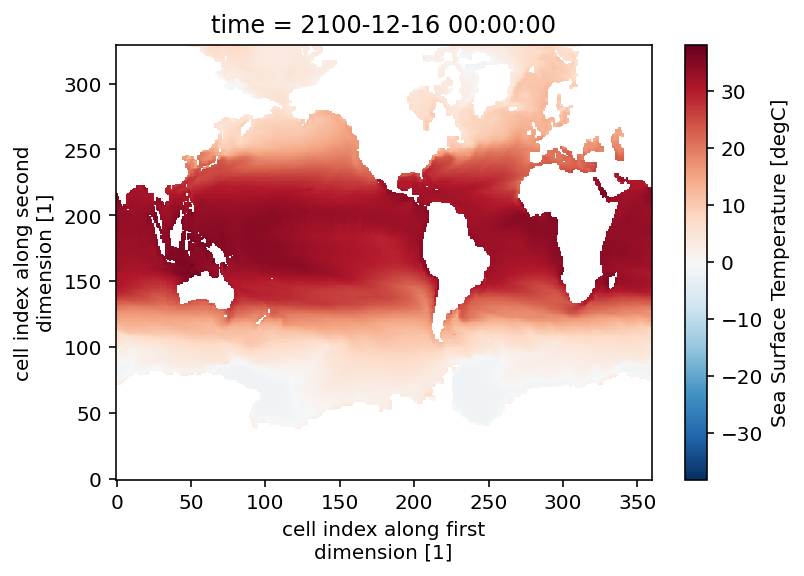

In [7]:
ds.tos.sel(time=ds.time[-1]).squeeze().plot()

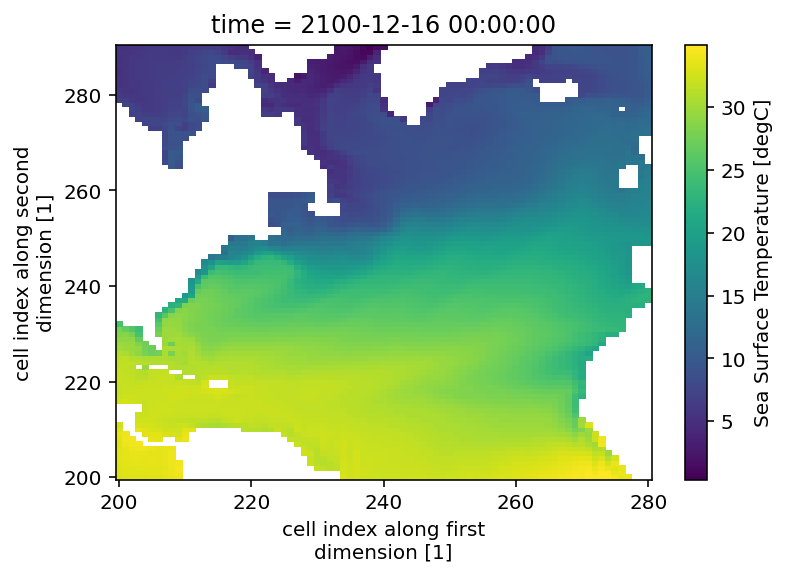

In [8]:
#Select the Atlantic Area
start_yr=2015
final_yr=2100
start_date="2015-01-16"
final_date="2100-12-16"
ds1 = ds.sel(i=slice(200,280)).sel(j=slice(200,290)).sel(time=slice(start_date,final_date))
ds1.tos.sel(time=ds1.time[-1]).squeeze().plot()


In [9]:
#Calculate the spatially averaged timeseries to have values per year
sst_clim = []
for i in range(start_yr,final_yr):
  sst_clim.append(ds1.sel(time=slice(str(i)+"-01-16", str(i)+"-12-16")).tos.mean("time").mean("i").mean("j"))

In [10]:
sst_clim= [np.float32(val) for val in sst_clim]

In [11]:
# We detrend the spatial averaged timeseries
from sklearn.linear_model import LinearRegression
X1= range(final_yr-start_yr)
alpha1 = LinearRegression().fit(np.reshape(X1,(-1, 1)), sst_clim)

Text(0.5, 1.0, 'Spatial averaged timeseries and its trend')

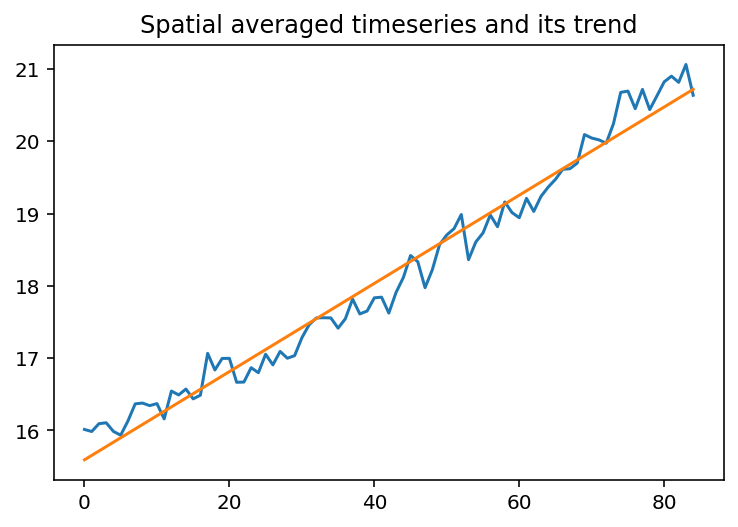

In [12]:
plt.plot(sst_clim)
plt.plot(alpha1.predict(np.reshape(X1,(-1, 1))))
plt.title("Spatial averaged timeseries and its trend")

In [13]:
sst_clim_detrend= sst_clim-alpha1.predict(np.reshape(X1,(-1, 1)))

Text(0.5, 1.0, 'Approximated AMO')

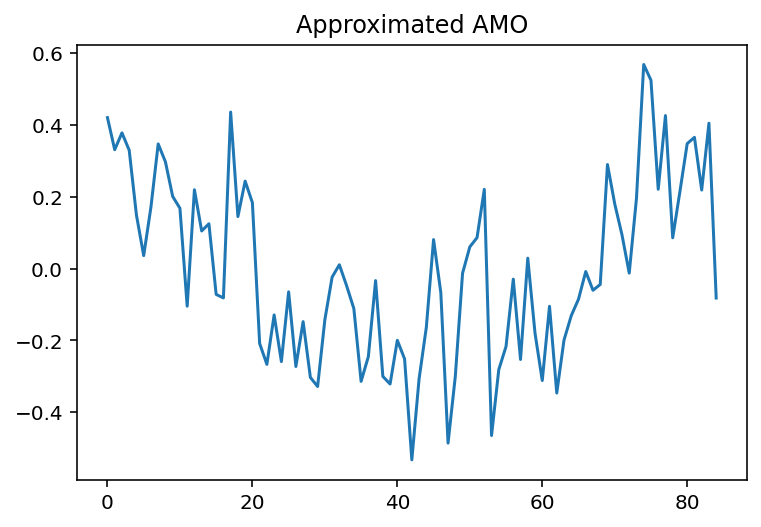

In [14]:
plt.plot(sst_clim_detrend)
plt.title("Approximated AMO")

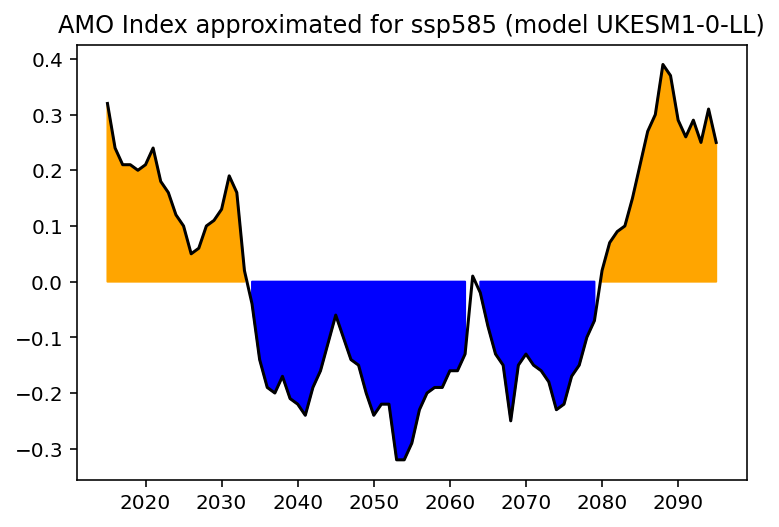

In [16]:
# Program to calculate moving average
window_size = 5
i = 0
# Initialize an empty list to store moving averages
moving_averages = []
# Loop through the array to consider every window of size 5
while i < len(sst_clim_detrend) - window_size + 1:
	
	# Store elements from i to i+window_size
	# in list to get the current window
	window = sst_clim_detrend[i : i + window_size]

	# Calculate the average of current window
	window_average = round(sum(window) / window_size, 2)
	
	# Store the average of current
	# window in moving average list
	moving_averages.append(window_average)
	
	# Shift window to right by one position
	i += 1
yrs=np.arange(start_yr,final_yr- window_size + 1,1) #problème on a que 154 valeurs avec moving average....
plt.plot(yrs,moving_averages,color='black')
plt.title("AMO Index approximated for ssp585 (model UKESM1-0-LL)")
plt.fill_between(
        x= yrs, 
        y1= moving_averages, 
        where= (0 < np.array(moving_averages)),
        color= "orange")
plt.fill_between(
        x= yrs, 
        y1= moving_averages, 
        where= (0 > np.array(moving_averages)),
        color= "blue")

In [17]:
# Transformation of sst to have mean per year in any location in the Atlantic
sst = []
for i in range(start_yr,final_yr):
  sst.append(ds1.sel(time=slice(str(i)+"-01-16", str(i)+"-12-16")).tos.mean("time"))


In [18]:
from sklearn.linear_model import LinearRegression
X=sst_clim_detrend
y=np.reshape(sst,(final_yr-start_yr,-1))
# Check for NaN values in the data
if np.isnan(y).any():
    print("Data contains NaN values.")
    y = np.nan_to_num(y)
    print("NaN values replaced with finite numbers.")

alpha = LinearRegression().fit(np.reshape(X,(-1, 1)), y)

Data contains NaN values.
NaN values replaced with finite numbers.


In [19]:
coeff=alpha.coef_
coeff=coeff.reshape(91,-1)

/usr/local/lib/python3.8/dist-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


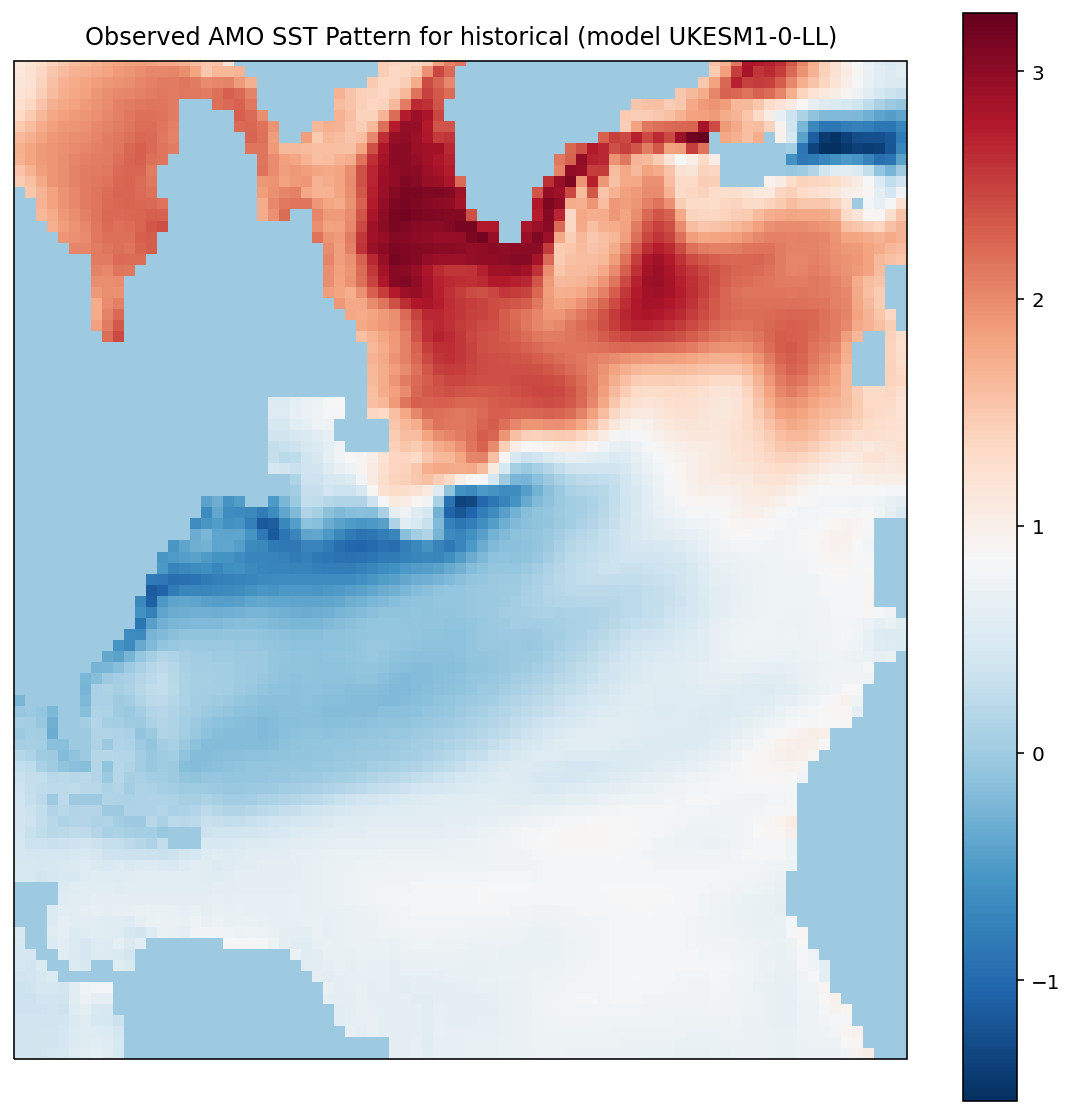

In [20]:
# Create a figure and an axis
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines and states
ax.add_feature(cfeature.STATES)

# Plot the AMO index
im = ax.imshow(coeff, origin='lower', cmap='RdBu_r')

# Add colorbar
# cbar = plt.colorbar(im,ax=ax)

# Add title
plt.title('Observed AMO SST Pattern for historical (model UKESM1-0-LL)')
cbar = plt.colorbar(im,ax=ax)
# Display the plot
plt.show()

# **Second experiment: piControl**

In [ ]:
df_tos = df_full.query("activity_id == 'CMIP' & institution_id == 'IPSL' & source_id=='IPSL-CM6A-LR' & experiment_id=='piControl' & member_id=='r1i1p1f1' & table_id == 'Omon' & variable_id == 'tos'")
print(df_tos.shape)
df_tos

(1, 11)


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
429164,CMIP,IPSL,IPSL-CM6A-LR,piControl,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...,NaN,20200326


In [ ]:
# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

# get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_tos.zstore.values[-1]
print(zstore)
# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)
ds

gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piControl/r1i1p1f1/Omon/tos/gn/v20200326/


/usr/local/lib/python3.8/dist-packages/xarray/coding/times.py:699: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.8/dist-packages/xarray/coding/times.py:699: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.8/dist-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


<xarray.Dataset>
Dimensions:         (y: 332, x: 362, nvertex: 4, time: 14400, axis_nbounds: 2)
Coordinates:
    bounds_nav_lat  (y, x, nvertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    bounds_nav_lon  (y, x, nvertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    nav_lat         (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    nav_lon         (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
  * time            (time) object 1850-01-16 12:00:00 ... 3049-12-16 12:00:00
    time_bounds     (time, axis_nbounds) object dask.array<chunksize=(14400, 2), meta=np.ndarray>
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    area            (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    tos             (time, y, x) float32 dask.array<chunksize=(252, 332, 362), meta=np.ndarray>
Attributes: (12/54)
    CMIP6_CV_version:       cv=6.2.3.5-2-g63b123e
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  piControl
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    ...                     ...
    tracking_id:            hdl:21.14100/640fb3e1-ddac-4da8-ac5a-339f83df1540...
    variable_id:            tos
    variant_info:           . Information provided by this attribute may in s...
    variant_label:          r1i1p1f1
    netcdf_tracking_ids:    hdl:21.14100/640fb3e1-ddac-4da8-ac5a-339f83df1540...
    version_id:             v20200326

In [ ]:
#Select the Atlantic Area
start_yr=1850
final_yr=2100
start_date="1850-01-01"
final_date="2100-12-31"
ds1 = ds.sel(x=slice(200,280)).sel(y=slice(210,280)).sel(time=slice(start_date,final_date))

In [ ]:
#Calculate the spatially averaged timeseries to have values per year
sst_clim = []
for i in range(start_yr,final_yr):
  sst_clim.append(ds1.sel(time=slice(str(i)+"-01-01", str(i)+"-12-31")).tos.mean("time").mean("x").mean("y"))

In [ ]:
sst_clim= [np.float32(val) for val in sst_clim]

In [ ]:
# We detrend the spatial averaged timeseries
from sklearn.linear_model import LinearRegression
X1= range(final_yr-start_yr)
alpha1 = LinearRegression().fit(np.reshape(X1,(-1, 1)), sst_clim)

Text(0.5, 1.0, 'Spatial averaged timeseries and its trend')

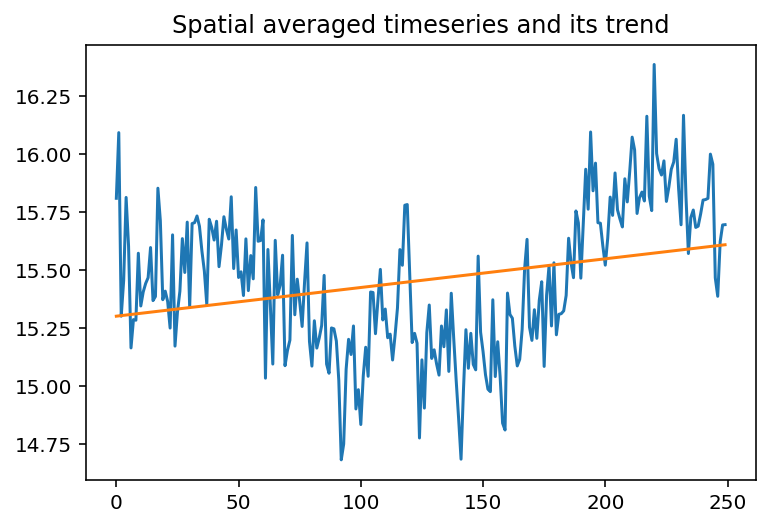

In [ ]:
plt.plot(sst_clim)
plt.plot(alpha1.predict(np.reshape(X1,(-1, 1))))
plt.title("Spatial averaged timeseries and its trend")

In [ ]:
sst_clim_detrend= sst_clim-alpha1.predict(np.reshape(X1,(-1, 1)))

Text(0.5, 1.0, 'Approximated AMO')

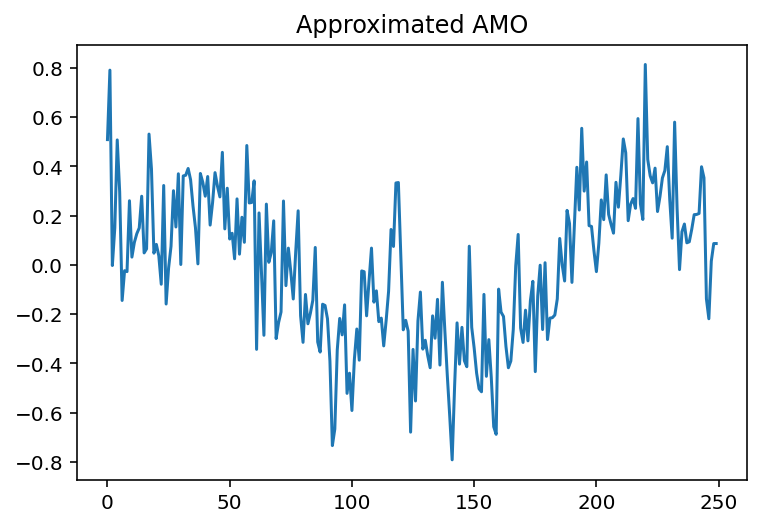

In [ ]:
plt.plot(sst_clim_detrend)
plt.title("Approximated AMO")

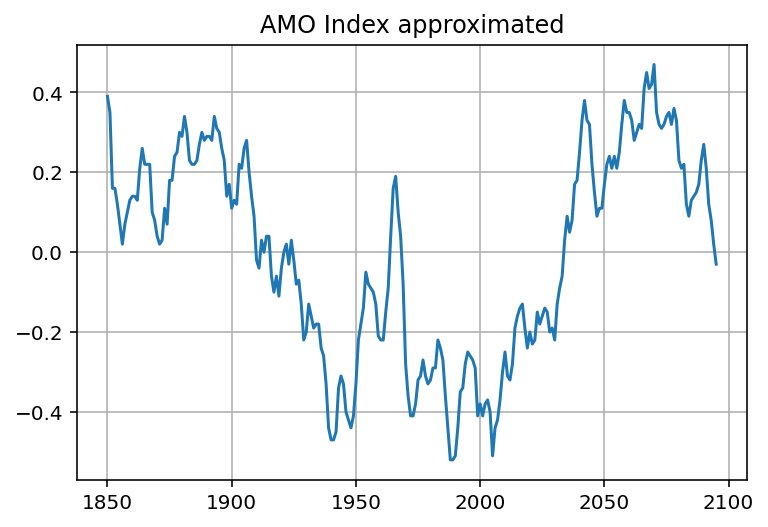

In [ ]:
# Program to calculate moving average
window_size = 5
i = 0
# Initialize an empty list to store moving averages
moving_averages = []
# Loop through the array to consider every window of size 5
while i < len(sst_clim_detrend) - window_size + 1:
	
	# Store elements from i to i+window_size
	# in list to get the current window
	window = sst_clim_detrend[i : i + window_size]

	# Calculate the average of current window
	window_average = round(sum(window) / window_size, 2)
	
	# Store the average of current
	# window in moving average list
	moving_averages.append(window_average)
	
	# Shift window to right by one position
	i += 1
yrs=np.arange(start_yr,final_yr- window_size + 1,1) #problème on a que 154 valeurs avec moving average....
plt.plot(yrs,moving_averages)
plt.title("AMO Index approximated")
plt.grid()

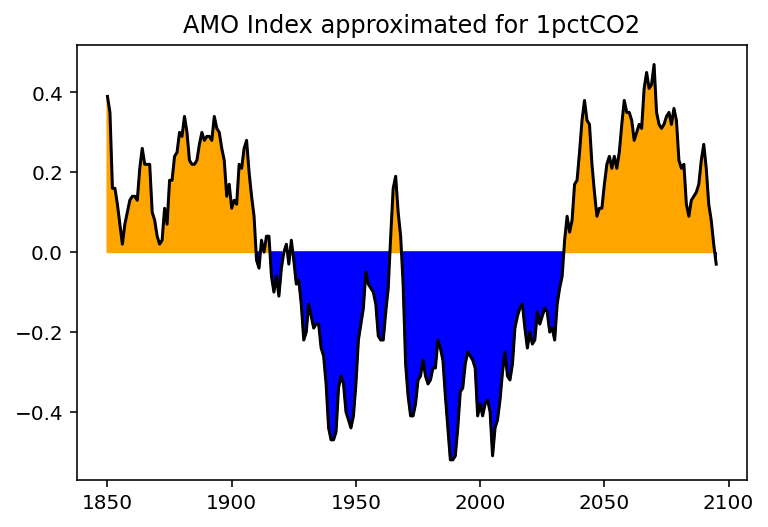

In [ ]:
yrs=np.arange(start_yr,final_yr- window_size + 1,1) #problème on a que 154 valeurs avec moving average....
plt.plot(yrs,moving_averages,color='black')
plt.title("AMO Index approximated for 1pctCO2")
plt.fill_between(
        x= yrs, 
        y1= moving_averages, 
        where= (0 < np.array(moving_averages)),
        color= "orange")
plt.fill_between(
        x= yrs, 
        y1= moving_averages, 
        where= (0 > np.array(moving_averages)),
        color= "blue")

In [ ]:
# Transformation of sst to have mean per year in any location in the Atlantic
sst = []
for i in range(start_yr,final_yr):
  sst.append(ds1.sel(time=slice(str(i)+"-01-01", str(i)+"-12-31")).tos.mean("time"))


In [ ]:
from sklearn.linear_model import LinearRegression
X=sst_clim_detrend
y=np.reshape(sst,(final_yr-start_yr,-1))
# Check for NaN values in the data
if np.isnan(y).any():
    print("Data contains NaN values.")
    y = np.nan_to_num(y)
    print("NaN values replaced with finite numbers.")

alpha = LinearRegression().fit(np.reshape(X,(-1, 1)), y)

Data contains NaN values.
NaN values replaced with finite numbers.


In [ ]:
coeff=alpha.coef_
coeff=coeff.reshape(70,-1)

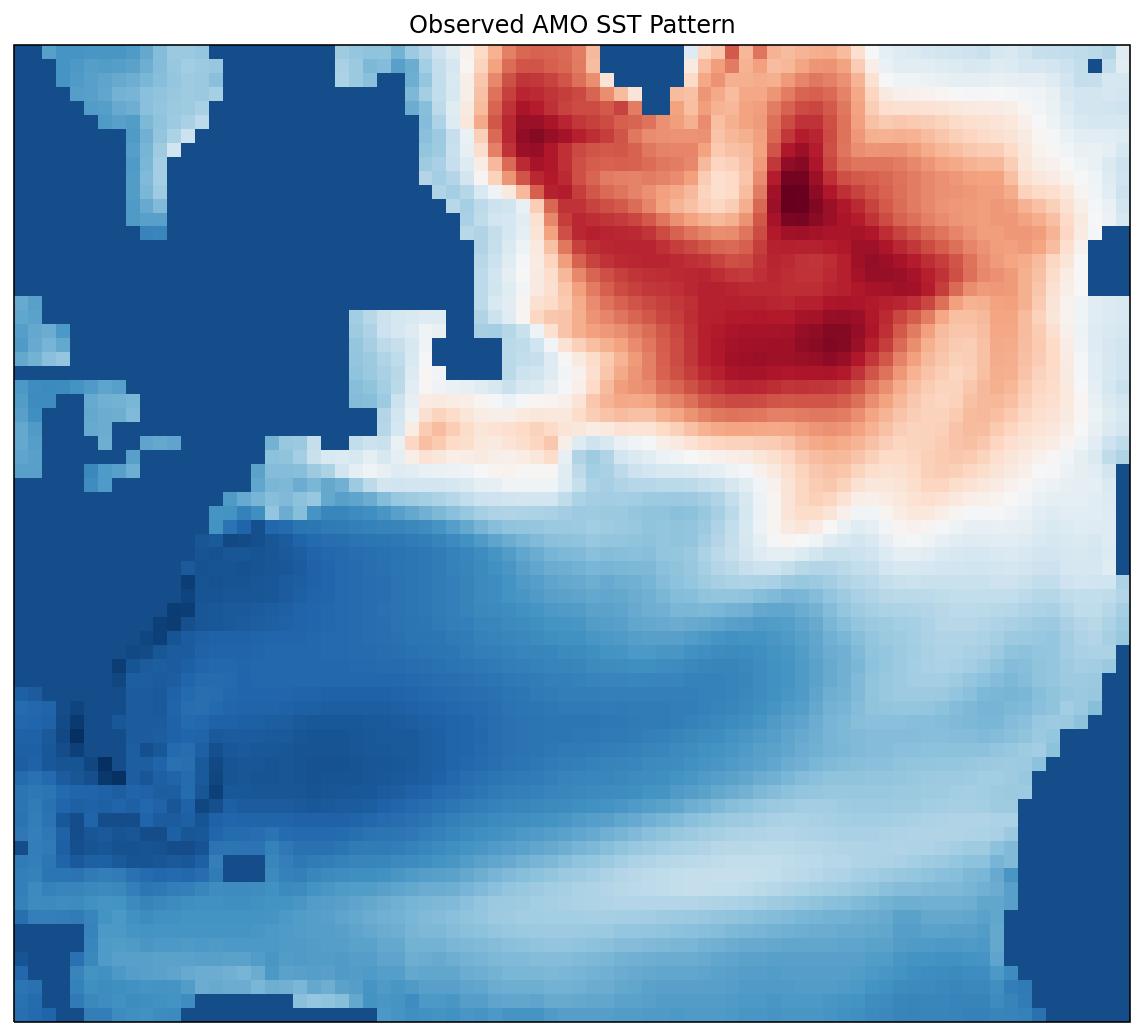

In [ ]:
# Create a figure and an axis
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines and states
ax.add_feature(cfeature.STATES)

# Plot the AMO index
im = ax.imshow(coeff, origin='lower', cmap='RdBu_r')

# Add colorbar
# cbar = plt.colorbar(im,ax=ax)

# Add title
plt.title('Observed AMO SST Pattern')

# Display the plot
plt.show()

# **Third experiment: 1pctCO2**

In [ ]:
one_pct_df = df_full.query("activity_id == 'CMIP' & institution_id == 'IPSL' & source_id=='IPSL-CM6A-LR' & experiment_id=='1pctCO2' & member_id=='r1i1p1f1' & table_id == 'Omon' & variable_id == 'tos'")
one_pct_df

(1, 11)


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
429164,CMIP,IPSL,IPSL-CM6A-LR,piControl,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...,NaN,20200326


In [ ]:
# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

# get the path to a specific zarr store (the first one from the dataframe above)
zstore = one_pct_df.zstore.values[-1]
print(zstore)
# create a mutable-mapping-style interface to the store
one_pct_mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
one_pct_data = xr.open_zarr(one_pct_mapper, consolidated=True)
one_pct_data

gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piControl/r1i1p1f1/Omon/tos/gn/v20200326/


/usr/local/lib/python3.8/dist-packages/xarray/coding/times.py:699: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.8/dist-packages/xarray/coding/times.py:699: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.8/dist-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


<xarray.Dataset>
Dimensions:         (y: 332, x: 362, nvertex: 4, time: 14400, axis_nbounds: 2)
Coordinates:
    bounds_nav_lat  (y, x, nvertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    bounds_nav_lon  (y, x, nvertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    nav_lat         (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    nav_lon         (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
  * time            (time) object 1850-01-16 12:00:00 ... 3049-12-16 12:00:00
    time_bounds     (time, axis_nbounds) object dask.array<chunksize=(14400, 2), meta=np.ndarray>
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    area            (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    tos             (time, y, x) float32 dask.array<chunksize=(252, 332, 362), meta=np.ndarray>
Attributes: (12/54)
    CMIP6_CV_version:       cv=6.2.3.5-2-g63b123e
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  piControl
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    ...                     ...
    tracking_id:            hdl:21.14100/640fb3e1-ddac-4da8-ac5a-339f83df1540...
    variable_id:            tos
    variant_info:           . Information provided by this attribute may in s...
    variant_label:          r1i1p1f1
    netcdf_tracking_ids:    hdl:21.14100/640fb3e1-ddac-4da8-ac5a-339f83df1540...
    version_id:             v20200326

In [ ]:
#Select the Atlantic Area
start_yr=1850
final_yr=2000
start_date="1850-01-16"
final_date="1999-12-1"
one_pct_atl = one_pct_data.sel(x=slice(200,280)).sel(y=slice(210,280)).sel(time=slice(start_date,final_date))

In [ ]:
#Calculate the spatially averaged timeseries to have values per year
one_pct_sst_avg = []
for i in range(start_yr,final_yr):
  one_pct_sst_avg.append(one_pct_atl.sel(time=slice(str(i)+"-01-01", str(i)+"-12-31")).tos.mean("time").mean("x").mean("y"))

In [ ]:
one_pct_sst_avg= [np.float32(val) for val in one_pct_sst_avg]

In [ ]:
# We detrend the spatial averaged timeseries
from sklearn.linear_model import LinearRegression
X1= range(final_yr-start_yr)
alpha1 = LinearRegression().fit(np.reshape(X1,(-1, 1)), one_pct_sst_avg)

Text(0.5, 1.0, 'Spatial averaged timeseries and its trend')

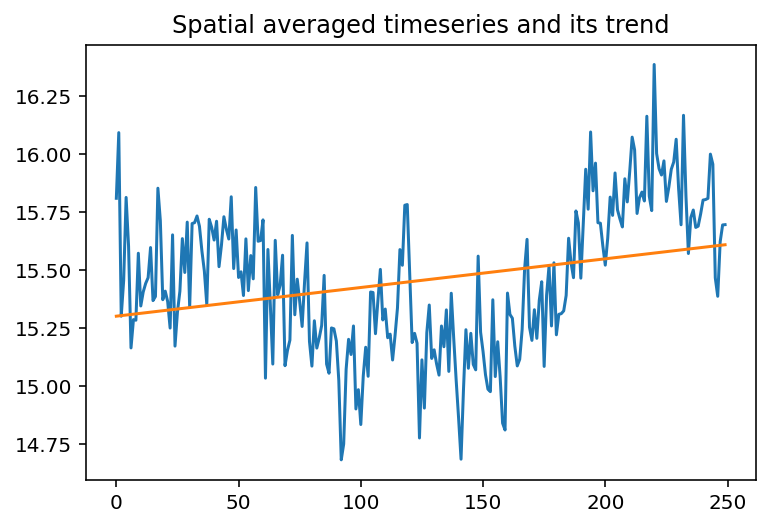

In [ ]:
plt.plot(one_pct_sst_avg)
plt.plot(alpha1.predict(np.reshape(X1,(-1, 1))))
plt.title("Spatial averaged timeseries and its trend")

In [ ]:
one_pct_sst_detrend= one_pct_sst_avg-alpha1.predict(np.reshape(X1,(-1, 1)))

Text(0.5, 1.0, 'Approximated AMO')

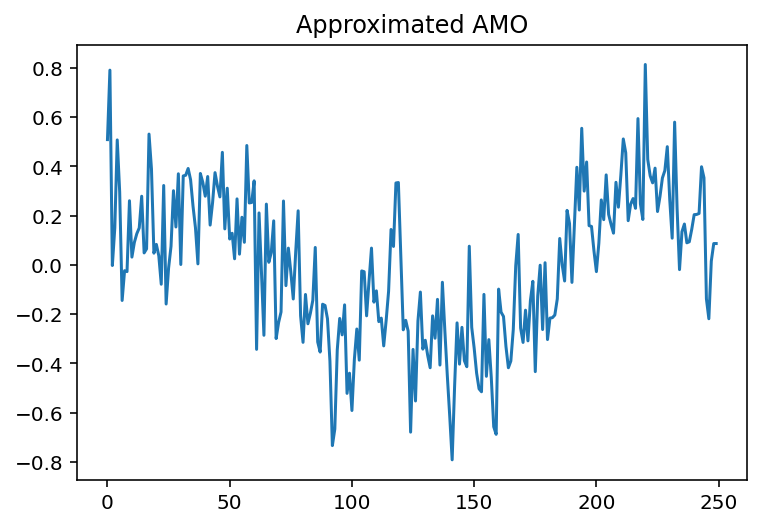

In [ ]:
plt.plot(one_pct_sst_detrend)
plt.title("Approximated AMO for experiment '1pctCO2'")

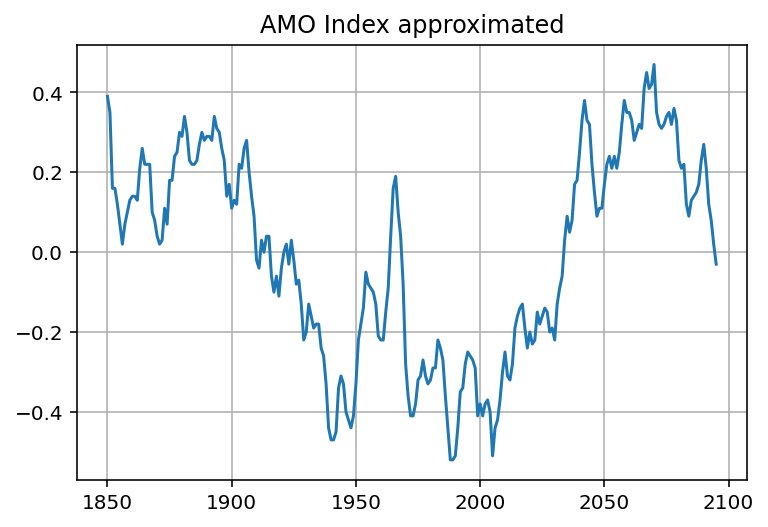

In [ ]:
# Program to calculate moving average
window_size = 5
i = 0
# Initialize an empty list to store moving averages
moving_averages = []
# Loop through the array to consider every window of size 5
while i < len(one_pct_sst_detrend) - window_size + 1:
	
	# Store elements from i to i+window_size
	# in list to get the current window
	window = one_pct_sst_detrend[i : i + window_size]

	# Calculate the average of current window
	window_average = round(sum(window) / window_size, 2)
	
	# Store the average of current
	# window in moving average list
	moving_averages.append(window_average)
	
	# Shift window to right by one position
	i += 1
yrs=np.arange(start_yr,final_yr- window_size + 1,1) #problème on a que 154 valeurs avec moving average....
plt.plot(yrs,moving_averages,color='black')
plt.title("AMO Index approximated for 1pctCO2")
plt.fill_between(
        x= yrs, 
        y1= moving_averages, 
        where= (0 < np.array(moving_averages)),
        color= "orange")
plt.fill_between(
        x= yrs, 
        y1= moving_averages, 
        where= (0 > np.array(moving_averages)),
        color= "blue")
plt.xlabel("Years")

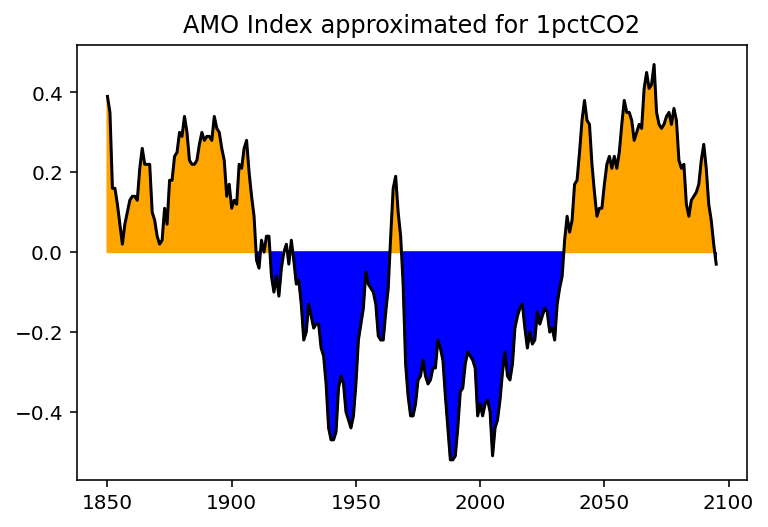

In [ ]:
yrs=np.arange(start_yr,final_yr- window_size + 1,1) #problème on a que 154 valeurs avec moving average....
plt.plot(yrs,moving_averages,color='black')
plt.title("AMO Index approximated for 1pctCO2")
plt.fill_between(
        x= yrs, 
        y1= moving_averages, 
        where= (0 < np.array(moving_averages)),
        color= "orange")
plt.fill_between(
        x= yrs, 
        y1= moving_averages, 
        where= (0 > np.array(moving_averages)),
        color= "blue")

In [ ]:
# Transformation of sst to have mean per year in any location in the Atlantic
sst_one_pct = []
for i in range(start_yr,final_yr):
  sst_one_pct.append(one_pct_atl.sel(time=slice(str(i)+"-01-01", str(i)+"-12-31")).tos.mean("time"))


In [ ]:
from sklearn.linear_model import LinearRegression
X=one_pct_sst_detrend
y=np.reshape(sst_one_pct,(final_yr-start_yr,-1))
# Check for NaN values in the data
if np.isnan(y).any():
    print("Data contains NaN values.")
    y = np.nan_to_num(y)
    print("NaN values replaced with finite numbers.")

alpha = LinearRegression().fit(np.reshape(X,(-1, 1)), y)

Data contains NaN values.
NaN values replaced with finite numbers.


In [ ]:
coeff=alpha.coef_
coeff=coeff.reshape(70,-1)

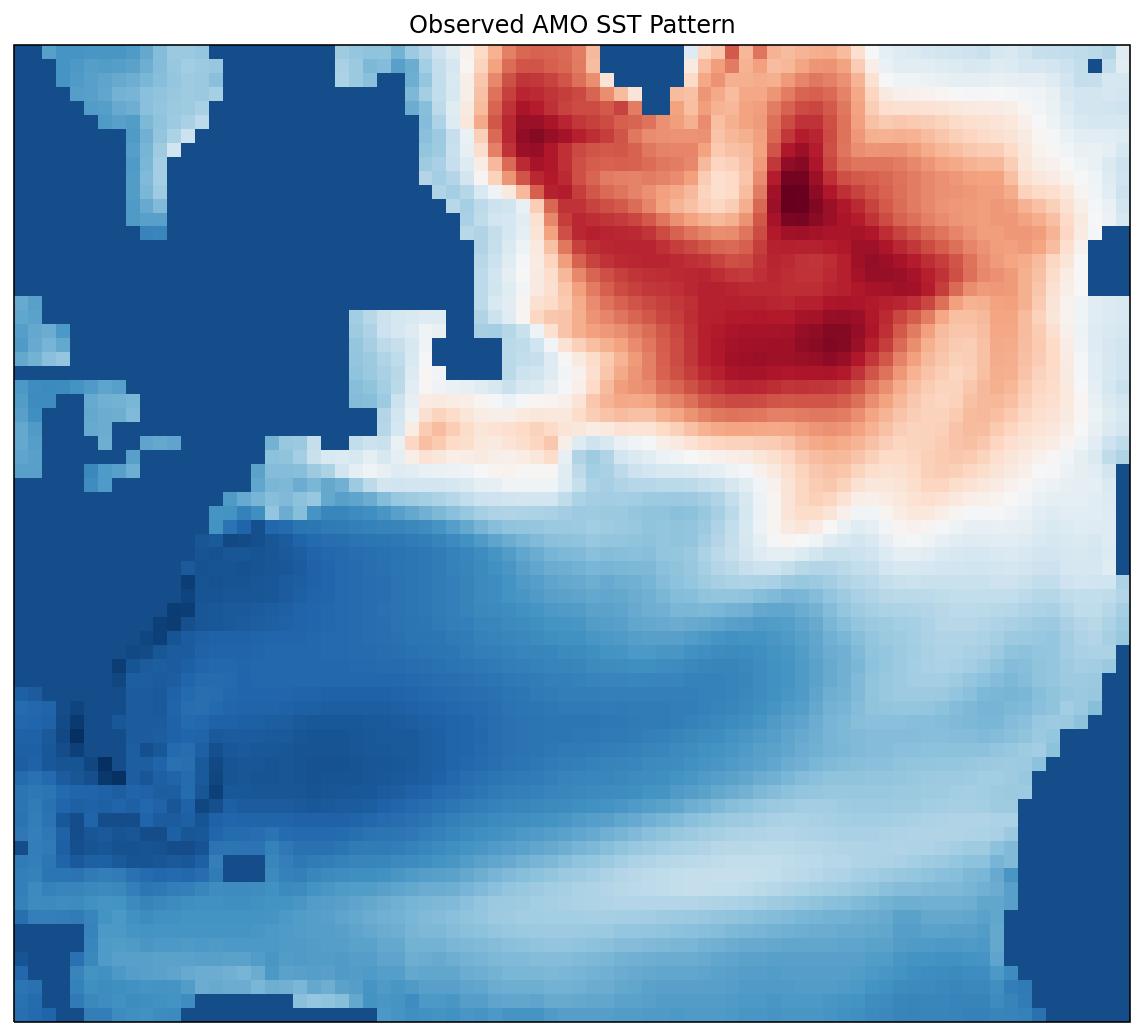

In [ ]:
# Create a figure and an axis
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines and states
ax.add_feature(cfeature.STATES)

# Plot the AMO index
im = ax.imshow(coeff, origin='lower', cmap='RdBu_r')

# Add colorbar
# cbar = plt.colorbar(im,ax=ax)

# Add title
plt.title('Observed AMO SST Pattern for 1pctCO2')

# Display the plot
plt.show()